In [1]:
from tensorflow.python.eager import backprop
from tensorflow.python.keras.engine import data_adapter
from tensorflow.python.keras.mixed_precision.experimental import loss_scale_optimizer as lso
from tensorflow.python.distribute import parameter_server_strategy
import tensorflow as tf
import pandas as pd
import numpy as np

import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import colors
plt.style.use('seaborn-whitegrid')

###Import self-written library
import featexlib.debug as dbug
import featexlib.datagen as dgen

Data is ok
Out shape X,Y is: (200000, 32, 84) (200000,)
Number of classes: 2000
Max class label (should starts from 0): 1999
Show first 10 images:


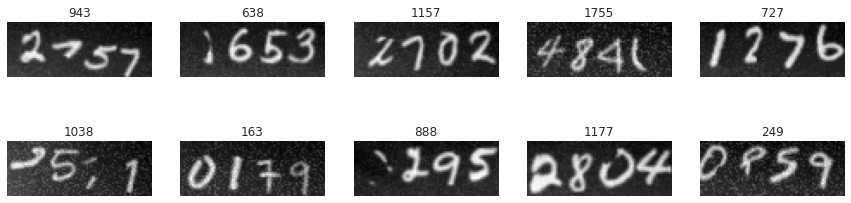

In [23]:
###Load data
###This cell should be used in another cell Can be used in another file

x_load, y_load = dgen.Image_generator.load_data(name="base_c100_32x84_classifier")

###Get information about dataset
y_uniq = len(np.unique(y_load))
y_max = y_load.max()

###Check if data is consistent
print("Data is ok" if (y_max+1)==y_uniq else "Data is NOT consistent! Y values should be from 0 to MAX, without gaps!!!")

###Show some report. Label is uniq for each class but it doesnt related to "real" image values
print("===================================")
print("Out shape X,Y is:",x_load.shape, y_load.shape)
print("Number of classes:",y_uniq)
print("Max class label (should starts from 0):", y_max)
print("Show first 10 images:")
dbug.Debug.show_images_list(x_load[:10], y_load[:10], col_number = 5)

In [24]:
###Split data to test and train
n_offset = 100000
n_train = 99000
n_test = 1000

def relabel_y(inp_y):
    inp_y_uniq = len(np.unique(inp_y))
    inp_y_max = inp_y.max()

    print("Number of classes:",inp_y_uniq)
    print("Max class label:", inp_y_max)
    print("Relabeling is not required" if (inp_y_max+1)==inp_y_uniq else "Y should be relabeled to 0-n")

    if not (inp_y_max+1)==inp_y_uniq:
        lookup_table = dict(zip(np.unique(inp_y), np.arange(len(np.unique(inp_y)))) )
        vect_lookup = np.vectorize(lookup_table.get)
        out_y = np.copy(inp_y)
        out_y = vect_lookup(out_y)
        print("Y was relabeled")
        print("New number of classes:", len(np.unique(out_y)))
        print("New max class label:", out_y.max())
        return out_y
    else:
        return inp_y

###Get X train and test

x_train, x_test = x_load[n_offset:n_offset+n_train], x_load[n_offset+n_train:n_offset+n_train+n_test]

###Relabel Y array to make it from 0 to n. Relabel test and train together!!!
y_train_test = relabel_y(y_load[n_offset:n_offset+n_train+n_test])
y_train, y_test = y_train_test[:n_train], y_train_test[n_train:n_train+n_test]
num_classes = len(np.unique(y_train_test))

print("===============Data is ready====================")
print("Shape X,Y for train:",x_train.shape,y_train.shape)
print("Shape X,Y for test: ",x_test.shape,y_test.shape)
print("Number of classes is:",num_classes)

###Clean memory
del x_load, y_load

Number of classes: 2000
Max class label: 1999
Relabeling is not required
===============Data is ready====================
Shape X,Y for train: (99000, 32, 84) (99000,)
Shape X,Y for test:  (1000, 32, 84) (1000,)
Number of classes is: 2000


In [25]:
###Reshape and then rescale dataset
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1))
x_test  = scaler.transform(x_test.reshape(x_test.shape[0],-1))

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(99000, 2688) (99000,) (1000, 2688) (1000,)


In [26]:
###Prepare for training: check labels dimension (-1), change X to float32 instead of float64
ys = y_train.astype(int).reshape(-1)
xs = x_train.astype('float32')
#ys_one_hot = tf.one_hot(ys, num_classes) ###not used

ys_test = y_test.astype(int).reshape(-1)
xs_test = x_test.astype('float32')

###Clear memory
del x_train, y_train, y_test, x_test

In [9]:
###Model parameters
pic_h = 32
pic_w = 84
num_feat = 256
#'num_classes' is defined before

###Minimizer taken from tf library. Actually, this code is redundant and can be simplified
def _minimize(strategy, tape, optimizer, loss, trainable_variables):
    """Minimizes loss for one step by updating `trainable_variables`.
    This is roughly equivalent to
    ```python
    gradients = tape.gradient(loss, trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, trainable_variables))
    ```
    However, this function also applies gradient clipping and loss scaling if the
    optimizer is a LossScaleOptimizer.
    Args:
    strategy: `tf.distribute.Strategy`.
    tape: A gradient tape. The loss must have been computed under this tape.
    optimizer: The optimizer used to minimize the loss.
    loss: The loss tensor.
    trainable_variables: The variables that will be updated in order to minimize
    the loss.
    """

    with tape:
        if isinstance(optimizer, lso.LossScaleOptimizer):
            loss = optimizer.get_scaled_loss(loss)

    gradients = tape.gradient(loss, trainable_variables)

    # Whether to aggregate gradients outside of optimizer. This requires support
    # of the optimizer and doesn't work with ParameterServerStrategy and
    # CentralStroageStrategy.
    aggregate_grads_outside_optimizer = (
        optimizer._HAS_AGGREGATE_GRAD and  # pylint: disable=protected-access
        not isinstance(strategy.extended,
                       parameter_server_strategy.ParameterServerStrategyExtended))

    if aggregate_grads_outside_optimizer:
        # We aggregate gradients before unscaling them, in case a subclass of
        # LossScaleOptimizer all-reduces in fp16. All-reducing in fp16 can only be
        # done on scaled gradients, not unscaled gradients, for numeric stability.
        gradients = optimizer._aggregate_gradients(zip(gradients,  # pylint: disable=protected-access
                                                       trainable_variables))
    if isinstance(optimizer, lso.LossScaleOptimizer):
        gradients = optimizer.get_unscaled_gradients(gradients)
    gradients = optimizer._clip_gradients(gradients)  # pylint: disable=protected-access
    if trainable_variables:
        if aggregate_grads_outside_optimizer:
            optimizer.apply_gradients(
                zip(gradients, trainable_variables),
                experimental_aggregate_gradients=False)
        else:
            optimizer.apply_gradients(zip(gradients, trainable_variables))

###Model build in low level way
class Model(tf.keras.Model):
    def __init__(self, cl_coeff, dropout_rate = 0.1, variance_epsilon=1e-3, stddev = 0.1, bias = 0.1):
        super(Model, self).__init__()
        
        ###Model is Lenet++ taken from 'A Discriminative Feature Learning Approachfor Deep Face Recognition'
        ###Num features is 'num_feat'
        ###Num classes is 'num_classes'
        
        #Input pixel numbers is pic_h*pic_w*1
        input_shape = (-1,pic_h,pic_w,1)
        
        ###Weights initialisation for convolution layers should be sqrt(2/k*k*c) as in Kaiming He's, 'Delving Deep into Rectifiers...')
        ###because using PReLU as activation function for Conv layers
        conv_init = tf.keras.initializers.he_normal()
        #conv_init = tf.random_normal_initializer(mean=0.0, stddev=stddev, seed=None)
        
        ###Biases initialisation for convolution layers. Should be zeroes.
        conv_bias_init = 'zeros'
        #conv_bias_init = tf.constant_initializer(bias)

        ###Model layers
        #1,2: (5/32)/1,2 x 2 PReLU
        #3: MaxPool 2/2,0
        #4,5: (5/64)/1,2 x 2 PReLU
        #6: MaxPool 2/2,0
        #7,8: (5/128)/1,2 x 2 PReLU
        #9: MaxPool 2/2,0 + Dropout
        #10: FC*num_feat - feature vector
        #11: FC*num_classes - output
        
        self.conv1_1 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init, input_shape=input_shape[1:])
        self.conv1_1_pr = self.get_conv_act(alpha=0.5)
        self.conv1_2 = tf.keras.layers.Conv2D(32, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv1_2_pr = self.get_conv_act(alpha=0.5)
        self.pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        self.conv2_1 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_1_pr = self.get_conv_act(alpha=0.3)
        self.conv2_2 = tf.keras.layers.Conv2D(64, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init)
        self.conv2_2_pr = self.get_conv_act(alpha=0.3)
        self.pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        ###For last two convolution layers added L1L2 regularizer
        self.conv3_1 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init) #, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01)
        self.conv3_1_pr = self.get_conv_act(alpha=0.2)
        self.conv3_2 = tf.keras.layers.Conv2D(128, 5, padding="same", bias_initializer=conv_bias_init, kernel_initializer=conv_init) #, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01)
        self.conv3_2_pr = self.get_conv_act(alpha=0.2)
        self.pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding='same')
        
        self.pool3_drop = tf.keras.layers.Dropout(dropout_rate)
        
        self.feat = tf.keras.layers.Dense(num_feat, kernel_regularizer = self.get_regularizer(l1=0.01, l2=0.01))
        self.out = tf.keras.layers.Dense(num_classes)
        
        ###Batch normalisation is not used
        #self.bn_conv1_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv2_2 = tf.keras.layers.BatchNormalization()
        #self.bn_conv3_2 = tf.keras.layers.BatchNormalization()
        #self.bn_feat = tf.keras.layers.BatchNormalization()
        #self.bn_out = tf.keras.layers.BatchNormalization()
        
        #Make centers tf.constants - because we update them manually
        self.centers = tf.constant(tf.zeros([num_classes,num_feat], dtype=tf.float32), name="centers")
        self.cl_coeff = cl_coeff
        self.dropout_rate = dropout_rate
        self.variance_epsilon = variance_epsilon
    
    def get_conv_act(self, alpha = 0.2):
        #return tf.keras.layers.LeakyReLU(alpha=alpha)
        return tf.keras.layers.PReLU(alpha_initializer = tf.constant_initializer(alpha))
    
    def get_regularizer(self,l1=0.01,l2=0.01):
        return tf.keras.regularizers.L1L2(l1=l1, l2=l2)
    
    def __call__(self, x, training=False):
        x_reshaped = tf.reshape(x, [-1,pic_h,pic_w,1])
        h_conv1_1 = self.conv1_1(x_reshaped)
        h_conv1_1_pr = self.conv1_1_pr(h_conv1_1)
        h_conv1_2 = self.conv1_2(h_conv1_1_pr)
        h_conv1_2_pr = self.conv1_2_pr(h_conv1_2)
        h_pool1 = self.pool1(h_conv1_2_pr)
        #h_pool1_bn = self.bn_conv1_2(h_pool1, training = training)
        
        #tf.print("W Conv1 var:",tf.nn.moments(h_conv1_2,axes=[0,1,2,3])[1])
        
        h_conv2_1 = self.conv2_1(h_pool1)
        h_conv2_1_pr = self.conv2_1_pr(h_conv2_1)
        h_conv2_2 = self.conv2_2(h_conv2_1_pr)
        h_conv2_2_pr = self.conv2_2_pr(h_conv2_2)
        h_pool2 = self.pool2(h_conv2_2_pr)
        #h_pool2_bn = self.bn_conv2_2(h_pool2, training = training)
        
        #tf.print("W Conv2 var:",tf.nn.moments(h_conv2_2,axes=[0,1,2,3])[1])
        
        h_conv3_1 = self.conv3_1(h_pool2)
        h_conv3_1_pr = self.conv3_1_pr(h_conv3_1)
        h_conv3_2 = self.conv3_2(h_conv3_1_pr)
        h_conv3_2_pr = self.conv3_2_pr(h_conv3_2)
        h_pool3 = self.pool3(h_conv3_2_pr)

        #tf.print("W Conv3 var:",tf.nn.moments(h_conv3_2,axes=[0,1,2,3])[1])
        
        h_pool3_flt = tf.reshape(h_pool3, [-1,h_pool3.shape[1]*h_pool3.shape[2]*h_pool3.shape[3]])  #tf.reshape(h_pool3, self.get_flat_shape(h_pool3))
        #h_pool3_bn = self.bn_conv3_2(h_pool3_flt, training = training)
        
        h_pool3_flt_drop = self.pool3_drop(h_pool3_flt,training = training)

        h_feat = self.feat(h_pool3_flt_drop)
        
        #tf.print("W Fc1   var:",tf.nn.moments(h_feat,axes=[0,1])[1])
        
        #features = self.bn_out(features, training = training)
        y_out = self.out(h_feat)
        
        #In case of library losses use softmax output
        return y_out, h_feat   #tf.nn.softmax(y_out)
    
    def set_center_loss_coeff(self, cl_coeff):
        self.cl_coeff = cl_coeff
    
    def get_center_loss(self, features, labels):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(tf.stop_gradient(self.centers), labels)
        center_loss = tf.reduce_sum(input_tensor=(features - centers_batch) ** 2, axis=[1])
        return center_loss

    def centers_update(self, features, labels, alpha):
        labels = tf.reshape(labels, [-1])
        centers_batch = tf.gather(self.centers, labels)
        diff = centers_batch - features

        unique_label, unique_idx, unique_count = tf.unique_with_counts(labels)
        appear_times = tf.gather(unique_count, unique_idx)
        appear_times = tf.reshape(appear_times, [-1, 1])

        diff = diff / tf.cast((1 + appear_times), tf.float32)
        diff = alpha * diff
        
        label_reshaped = tf.reshape(labels,[-1,1])
        
        self.centers = tf.tensor_scatter_nd_sub(self.centers, label_reshaped, diff)
        
    def get_losses(self, x, y, training=False):
        y_pred, h_features = self(x, training=training)
        return self._get_losses(y, y_pred, h_features)

    def _get_losses(self, y, y_pred, h_features):
        y_one_hot = tf.one_hot(y, num_classes)
        center_loss = self.get_center_loss(h_features, y)
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_one_hot), logits=y_pred)
        tf.print("Using loss with center loss coeff:", self.cl_coeff)
        loss = tf.reduce_mean(input_tensor=(softmax_loss + self.cl_coeff * center_loss)) #    
        return loss, softmax_loss, center_loss
    
    def get_accuracy(self, x, y):
        y_pred, _ = self(x, training=False)
        result = tf.argmax(input=y_pred,axis=1)
        ground_truth = tf.reshape(y, [-1])
        correct_prediction = tf.equal(result, ground_truth)
        accuracy = tf.reduce_mean(input_tensor=tf.cast(correct_prediction, tf.float32))
        return accuracy
    
    def get_centers(self):
        return self.centers
    
    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        x, y, sample_weight = data_adapter.unpack_x_y_sample_weight(data)

        with backprop.GradientTape() as tape:
            y_pred, h_features = self(x, training=True)
            ###Calculate centerloss but don't include it in loss function
            loss, softmax_loss, center_loss = self._get_losses(y, y_pred, h_features) 
            #Default loss cant be used...
            #loss = self.compiled_loss(y, y_pred, sample_weight, regularization_losses=self.losses)
        
        ###Simple optimiser, not used.
        #trainable_variables = self.trainable_variables
        #gradients = tape.gradient(loss, trainable_variables)
        #self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        _minimize(self.distribute_strategy, tape, self.optimizer, loss,
                  self.trainable_variables)
        
        ###Update center loss    
        self.centers_update(h_features, y, 0.5) 
        
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
        
        #trace output
        tf.print({m.name: m.result() for m in self.metrics})
        
        return {m.name: m.result() for m in self.metrics}
    
    def save_model(self, name, save_dir = "models"):
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        self.save_weights(os.path.join(save_dir, name))

    def load_model(self, name, load_dir = "models"):
        self.load_weights(os.path.join(load_dir, name))
        
#Not used here, because can't implement center loss
class Softmax_and_center_loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        softmax_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf.stop_gradient(y_true), logits=y_pred)
        loss = tf.reduce_mean(input_tensor=softmax_loss ) 
        return loss

#Helpful function to control center loss during training    
def center_loss_progress(n_prog,n_iter, koeff):
    return koeff*(n_prog+1)/(n_iter) if n_prog<n_iter else koeff    


In [10]:
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
model.compile(opt, loss=model_loss, metrics=["accuracy"])

In [27]:
###Train model with centerloss 0.1 dropout 0.15, batch size 256, 20 epochs (center loss needs more). Train/test accuracy = ...

bunch_len = 256
dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 5
n_center_loss_epochs_progress = 5
c_loss = 0.1

for epoch in range(n_epochs):
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for i, batch in enumerate(dataset_batches):    
        print("Epoch #%s, %s/%s"%(epoch ,i, int(len(xs)/bunch_len)))
        model.set_center_loss_coeff(center_loss_progress(epoch,n_center_loss_epochs_progress,c_loss))
        model.train_step(batch)
        
print("====================================================")
#print("Final accuracy should be discovered manually")
#print("Final train Accuracy:", model.get_accuracy(xs, ys))        
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))     

Epoch #0, 0/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.894628227}
Epoch #0, 1/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.894176126}
Epoch #0, 2/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.893716395}
Epoch #0, 3/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.893255174}
Epoch #0, 4/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.892794371}
Epoch #0, 5/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.892334104}
Epoch #0, 6/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.891874254}
Epoch #0, 7/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.89141494}
Epoch #0, 8/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.890958071}
Epoch #0, 9/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.890499651}
Epoch #0, 10/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.890043736}
Epoch #0, 11/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.889588237}
Epoch #0, 12/38

Using loss with center loss coeff: 0.02
{'accuracy': 0.851117969}
Epoch #0, 100/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.850699604}
Epoch #0, 101/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.850281715}
Epoch #0, 102/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.849864185}
Epoch #0, 103/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.849449039}
Epoch #0, 104/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.849032342}
Epoch #0, 105/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.848616064}
Epoch #0, 106/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.848202109}
Epoch #0, 107/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.847786665}
Epoch #0, 108/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.847371578}
Epoch #0, 109/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.846956968}
Epoch #0, 110/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.846542716}
Epoch #0, 

{'accuracy': 0.812026262}
Epoch #0, 198/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.811645508}
Epoch #0, 199/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.811266959}
Epoch #0, 200/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.81088686}
Epoch #0, 201/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.810507178}
Epoch #0, 202/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.810127854}
Epoch #0, 203/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.809748828}
Epoch #0, 204/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.80937022}
Epoch #0, 205/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.808991909}
Epoch #0, 206/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.808614}
Epoch #0, 207/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.80823642}
Epoch #0, 208/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.80786103}
Epoch #0, 209/386
Using loss with center loss coeff: 0.02

{'accuracy': 0.776367605}
Epoch #0, 296/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.776019573}
Epoch #0, 297/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.77567184}
Epoch #0, 298/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.775326133}
Epoch #0, 299/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.774979}
Epoch #0, 300/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.774632215}
Epoch #0, 301/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.774285734}
Epoch #0, 302/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.77393949}
Epoch #0, 303/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.773593605}
Epoch #0, 304/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.773248076}
Epoch #0, 305/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.772902787}
Epoch #0, 306/386
Using loss with center loss coeff: 0.02
{'accuracy': 0.772557855}
Epoch #0, 307/386
Using loss with center loss coeff: 0.

Epoch #1, 7/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.743473709}
Epoch #1, 8/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.743156195}
Epoch #1, 9/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.742838919}
Epoch #1, 10/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.742520332}
Epoch #1, 11/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.742201924}
Epoch #1, 12/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.741883874}
Epoch #1, 13/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.741566062}
Epoch #1, 14/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.741248488}
Epoch #1, 15/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.740931213}
Epoch #1, 16/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.740614235}
Epoch #1, 17/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.740297496}
Epoch #1, 18/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.739981055}
Epoch #

Epoch #1, 106/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.713184297}
Epoch #1, 107/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.712890565}
Epoch #1, 108/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.712597132}
Epoch #1, 109/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.712303936}
Epoch #1, 110/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.71201092}
Epoch #1, 111/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.711718202}
Epoch #1, 112/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.711425722}
Epoch #1, 113/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.711135089}
Epoch #1, 114/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.710843086}
Epoch #1, 115/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.710552871}
Epoch #1, 116/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.710261345}
Epoch #1, 117/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.7099

Epoch #1, 204/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.685543239}
Epoch #1, 205/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.685271859}
Epoch #1, 206/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.685000718}
Epoch #1, 207/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.684729815}
Epoch #1, 208/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.68445909}
Epoch #1, 209/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.684188604}
Epoch #1, 210/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.683918297}
Epoch #1, 211/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.683649778}
Epoch #1, 212/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.683381438}
Epoch #1, 213/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.683111787}
Epoch #1, 214/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.682842374}
Epoch #1, 215/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.6825

Epoch #1, 302/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.659964442}
Epoch #1, 303/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.659713}
Epoch #1, 304/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.659461677}
Epoch #1, 305/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.659212053}
Epoch #1, 306/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.658961177}
Epoch #1, 307/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.65871191}
Epoch #1, 308/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.658461392}
Epoch #1, 309/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.658212543}
Epoch #1, 310/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.657963872}
Epoch #1, 311/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.65771395}
Epoch #1, 312/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.657464147}
Epoch #1, 313/386
Using loss with center loss coeff: 0.04
{'accuracy': 0.65721458

{'accuracy': 0.636783242}
Epoch #2, 12/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.636549175}
Epoch #2, 13/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.636315227}
Epoch #2, 14/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.636082888}
Epoch #2, 15/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.635850728}
Epoch #2, 16/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.635617316}
Epoch #2, 17/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.635384083}
Epoch #2, 18/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.635150969}
Epoch #2, 19/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.634918094}
Epoch #2, 20/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.634685338}
Epoch #2, 21/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.63445

{'accuracy': 0.61774081}
Epoch #2, 96/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.617520511}
Epoch #2, 97/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.617300391}
Epoch #2, 98/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.61708039}
Epoch #2, 99/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.616860569}
Epoch #2, 100/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.616640866}
Epoch #2, 101/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.616421342}
Epoch #2, 102/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.616203368}
Epoch #2, 103/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.615986943}
Epoch #2, 104/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.615767896}
Epoch #2, 105/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.6

Epoch #2, 179/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.599832237}
Epoch #2, 180/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.599624515}
Epoch #2, 181/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.599418342}
Epoch #2, 182/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.599212289}
Epoch #2, 183/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.599005}
Epoch #2, 184/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.598797858}
Epoch #2, 185/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.59859091}
Epoch #2, 186/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.598384082}
Epoch #2, 187/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.598178744}
Epoch #2, 188/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.597973526}
Epoch #2, 189/

Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.583125949}
Epoch #2, 263/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.582931}
Epoch #2, 264/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.582734883}
Epoch #2, 265/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.582540154}
Epoch #2, 266/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.582344294}
Epoch #2, 267/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.582149863}
Epoch #2, 268/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.581955552}
Epoch #2, 269/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.581760108}
Epoch #2, 270/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.581567347}
Epoch #2, 271/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.581372142}
Epoch #2, 272/386
Using loss wi

Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.567321658}
Epoch #2, 346/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.56713593}
Epoch #2, 347/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.566951573}
Epoch #2, 348/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.566766}
Epoch #2, 349/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.566581905}
Epoch #2, 350/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.566396654}
Epoch #2, 351/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.566211462}
Epoch #2, 352/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.566027701}
Epoch #2, 353/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.565844059}
Epoch #2, 354/386
Using loss with center loss coeff: 0.06000000000000001
{'accuracy': 0.565660536}
Epoch #2, 355/386
Using loss wit

{'accuracy': 0.551004}
Epoch #3, 50/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.550828755}
Epoch #3, 51/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.550654888}
Epoch #3, 52/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.550479889}
Epoch #3, 53/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.550306261}
Epoch #3, 54/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.550132751}
Epoch #3, 55/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.54995811}
Epoch #3, 56/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.54978478}
Epoch #3, 57/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.549610317}
Epoch #3, 58/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.549436033}
Epoch #3, 59/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.549261808}
Epoch #3, 60/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.549088895}
Epoch #3, 61/386
Using loss with center loss coeff: 0.08
{'accurac

{'accuracy': 0.534257889}
Epoch #3, 149/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.534093201}
Epoch #3, 150/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.533928633}
Epoch #3, 151/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.533764124}
Epoch #3, 152/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.533600926}
Epoch #3, 153/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.533436596}
Epoch #3, 154/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.533274829}
Epoch #3, 155/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.53311193}
Epoch #3, 156/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.53294915}
Epoch #3, 157/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.532785237}
Epoch #3, 158/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.532621443}
Epoch #3, 159/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.532458961}
Epoch #3, 160/386
Using loss with center loss coeff:

{'accuracy': 0.518658102}
Epoch #3, 247/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.518502891}
Epoch #3, 248/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.518348932}
Epoch #3, 249/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.518195093}
Epoch #3, 250/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.518043697}
Epoch #3, 251/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.51789}
Epoch #3, 252/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.517737567}
Epoch #3, 253/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.517584085}
Epoch #3, 254/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.517429531}
Epoch #3, 255/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.51727742}
Epoch #3, 256/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.517124176}
Epoch #3, 257/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.516969919}
Epoch #3, 258/386
Using loss with center loss coeff: 0.

{'accuracy': 0.503978074}
Epoch #3, 345/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.503832698}
Epoch #3, 346/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.503687441}
Epoch #3, 347/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.503542185}
Epoch #3, 348/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.503397107}
Epoch #3, 349/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.503253162}
Epoch #3, 350/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.503108203}
Epoch #3, 351/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.502963364}
Epoch #3, 352/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.502819657}
Epoch #3, 353/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.502676129}
Epoch #3, 354/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.502530336}
Epoch #3, 355/386
Using loss with center loss coeff: 0.08
{'accuracy': 0.502386928}
Epoch #3, 356/386
Using loss with center loss coef

Epoch #4, 57/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.489876896}
Epoch #4, 58/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.489739597}
Epoch #4, 59/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.48960346}
Epoch #4, 60/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.489465207}
Epoch #4, 61/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.489328146}
Epoch #4, 62/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.489190072}
Epoch #4, 63/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.48905316}
Epoch #4, 64/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.488915205}
Epoch #4, 65/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.488777339}
Epoch #4, 66/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.488639563}
Epoch #4, 67/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.488504052}
Epoch #4, 68/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.488366425}
Epoch #4, 69/386
U

{'accuracy': 0.476640701}
Epoch #4, 157/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.47650969}
Epoch #4, 158/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.476379842}
Epoch #4, 159/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.476252198}
Epoch #4, 160/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.476121426}
Epoch #4, 161/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475991786}
Epoch #4, 162/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475861132}
Epoch #4, 163/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475731641}
Epoch #4, 164/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475603282}
Epoch #4, 165/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475474983}
Epoch #4, 166/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475344628}
Epoch #4, 167/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.475216478}
Epoch #4, 168/386
Using loss with center loss coeff: 0.1
{'acc

{'accuracy': 0.464114249}
Epoch #4, 256/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463990092}
Epoch #4, 257/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463869095}
Epoch #4, 258/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463745058}
Epoch #4, 259/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463623166}
Epoch #4, 260/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463499248}
Epoch #4, 261/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463378549}
Epoch #4, 262/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463255793}
Epoch #4, 263/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463133126}
Epoch #4, 264/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.463009477}
Epoch #4, 265/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.46288693}
Epoch #4, 266/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.462764442}
Epoch #4, 267/386
Using loss with center loss coeff: 0.1
{'acc

{'accuracy': 0.452249765}
Epoch #4, 355/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.45213291}
Epoch #4, 356/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.452015072}
Epoch #4, 357/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.45189935}
Epoch #4, 358/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.4517847}
Epoch #4, 359/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.451668084}
Epoch #4, 360/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.45155254}
Epoch #4, 361/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.45143503}
Epoch #4, 362/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.451317579}
Epoch #4, 363/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.451200187}
Epoch #4, 364/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.451085895}
Epoch #4, 365/386
Using loss with center loss coeff: 0.1
{'accuracy': 0.45097065}
Epoch #4, 366/386
Using loss with center loss coeff: 0.1
{'accuracy'

In [10]:
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))    

Final test Accuracy: tf.Tensor(0.0, shape=(), dtype=float32)


In [12]:
###Save model after training
model.save_model("dig4_256f_e5_cl2000_acc0975")    

In [20]:
###Load model and retrain
model = Model(0.1, dropout_rate = 0.15, variance_epsilon=1e-3, stddev = 0.01, bias = 0.1)
model_loss = Softmax_and_center_loss()
opt = tf.keras.optimizers.Adam()#learning_rate=1e-4
bunch_len = 256
model.compile(opt, loss=model_loss, metrics=["accuracy"])
model.load_model("dig4_128f_e5_cl01_acc088") 
    
dataset = tf.data.Dataset.from_tensor_slices((xs, ys))
dataset_batches = dataset.batch(bunch_len)

n_epochs = 1
n_center_loss_progress = 5

for i in range(n_epochs):
    tf.print("Step #"+str(i))
    #loss, softmax_loss, center_loss = model.get_losses(xs, ys)
    #tf.print('Accuracy: ', model.get_accuracy(xs, ys))
    #tf.print('=== Full loss   :', loss)
    #tf.print('=== Softmax loss: ', softmax_loss)
    #tf.print('=== Center loss : ', tf.reduce_mean(center_loss))
    #tf.print('Centers: ', model.get_centers())
    for batch in dataset_batches:    
        model.set_center_loss_coeff(center_loss_progress(i,n_center_loss_progress,0.1))
        model.train_step(batch)
        
print("====================================================")

Step #0
W Conv1 var: 0.852401376
W Conv2 var: 0.579342365
W Conv3 var: 0.206285521
W Fc1   var: 0.726625919
Using loss with center loss coeff: 0.02
{'accuracy': 0.6953125}
W Conv1 var: 0.853065193
W Conv2 var: 0.576066434
W Conv3 var: 0.208188191
W Fc1   var: 0.686941803
Using loss with center loss coeff: 0.02
{'accuracy': 0.755859375}
W Conv1 var: 0.848153412
W Conv2 var: 0.561729312
W Conv3 var: 0.20927079
W Fc1   var: 0.618988335
Using loss with center loss coeff: 0.02
{'accuracy': 0.77734375}
W Conv1 var: 0.859656394
W Conv2 var: 0.571206093
W Conv3 var: 0.219936803
W Fc1   var: 0.632297039
Using loss with center loss coeff: 0.02
{'accuracy': 0.717773438}
W Conv1 var: 0.850153804
W Conv2 var: 0.57793355
W Conv3 var: 0.228428617
W Fc1   var: 0.686730802
Using loss with center loss coeff: 0.02
{'accuracy': 0.728125}
W Conv1 var: 0.838516414
W Conv2 var: 0.567587435
W Conv3 var: 0.225139543
W Fc1   var: 0.717642844
Using loss with center loss coeff: 0.02
{'accuracy': 0.751953125}
W Co

{'accuracy': 0.923958361}
W Conv1 var: 0.905166
W Conv2 var: 0.644985378
W Conv3 var: 0.24833934
W Fc1   var: 0.759014726
Using loss with center loss coeff: 0.02
{'accuracy': 0.925017}
W Conv1 var: 0.890243411
W Conv2 var: 0.629715323
W Conv3 var: 0.237477899
W Fc1   var: 0.783255577
Using loss with center loss coeff: 0.02
{'accuracy': 0.926113725}
W Conv1 var: 0.875335515
W Conv2 var: 0.61527431
W Conv3 var: 0.2300203
W Fc1   var: 0.82708168
Using loss with center loss coeff: 0.02
{'accuracy': 0.927246094}
W Conv1 var: 0.869425118
W Conv2 var: 0.609079242
W Conv3 var: 0.228119284
W Fc1   var: 0.817515373
Using loss with center loss coeff: 0.02
{'accuracy': 0.928172827}
W Conv1 var: 0.900200963
W Conv2 var: 0.641442657
W Conv3 var: 0.245862827
W Fc1   var: 0.78091532
Using loss with center loss coeff: 0.02
{'accuracy': 0.929218769}
W Conv1 var: 0.895946205
W Conv2 var: 0.637569785
W Conv3 var: 0.241053537
W Fc1   var: 0.797118902
Using loss with center loss coeff: 0.02
{'accuracy': 0.9

{'accuracy': 0.954276323}
W Conv1 var: 0.917399645
W Conv2 var: 0.663718343
W Conv3 var: 0.259335488
W Fc1   var: 0.803509355
Using loss with center loss coeff: 0.02
{'accuracy': 0.954671204}
W Conv1 var: 0.901729107
W Conv2 var: 0.654324174
W Conv3 var: 0.255832493
W Fc1   var: 0.895419598
Using loss with center loss coeff: 0.02
{'accuracy': 0.955017745}
W Conv1 var: 0.938969195
W Conv2 var: 0.702420533
W Conv3 var: 0.269274652
W Fc1   var: 0.943819523
Using loss with center loss coeff: 0.02
{'accuracy': 0.955317259}
W Conv1 var: 0.901846647
W Conv2 var: 0.664592743
W Conv3 var: 0.25924179
W Fc1   var: 0.86656177
Using loss with center loss coeff: 0.02
{'accuracy': 0.955610812}
W Conv1 var: 0.90139246
W Conv2 var: 0.668767154
W Conv3 var: 0.264075398
W Fc1   var: 0.770765126
Using loss with center loss coeff: 0.02
{'accuracy': 0.956015646}
W Conv1 var: 0.904561162
W Conv2 var: 0.675391316
W Conv3 var: 0.261133462
W Fc1   var: 0.861857831
Using loss with center loss coeff: 0.02
{'accur

Using loss with center loss coeff: 0.02
{'accuracy': 0.966460109}
W Conv1 var: 0.923498631
W Conv2 var: 0.700985134
W Conv3 var: 0.289446741
W Fc1   var: 0.897628307
Using loss with center loss coeff: 0.02
{'accuracy': 0.966689825}
W Conv1 var: 0.93293345
W Conv2 var: 0.711854398
W Conv3 var: 0.29492414
W Fc1   var: 0.897006869
Using loss with center loss coeff: 0.02
{'accuracy': 0.966810167}
W Conv1 var: 0.922038376
W Conv2 var: 0.703473151
W Conv3 var: 0.282475799
W Fc1   var: 0.928789496
Using loss with center loss coeff: 0.02
{'accuracy': 0.967008}
W Conv1 var: 0.943079829
W Conv2 var: 0.734572232
W Conv3 var: 0.292087823
W Fc1   var: 0.944028378
Using loss with center loss coeff: 0.02
{'accuracy': 0.967150807}
W Conv1 var: 0.923801422
W Conv2 var: 0.7046538
W Conv3 var: 0.27274394
W Fc1   var: 0.904693
Using loss with center loss coeff: 0.02
{'accuracy': 0.9673177}
W Conv1 var: 0.920359492
W Conv2 var: 0.696407616
W Conv3 var: 0.26951167
W Fc1   var: 0.908806443
Using loss with ce

W Fc1   var: 1.01037049
Using loss with center loss coeff: 0.02
{'accuracy': 0.973157048}
W Conv1 var: 0.928641617
W Conv2 var: 0.713717222
W Conv3 var: 0.287321121
W Fc1   var: 0.965318501
Using loss with center loss coeff: 0.02
{'accuracy': 0.973254144}
W Conv1 var: 0.946028948
W Conv2 var: 0.736651719
W Conv3 var: 0.296793222
W Fc1   var: 0.934028387
Using loss with center loss coeff: 0.02
{'accuracy': 0.973350227}
W Conv1 var: 0.954358935
W Conv2 var: 0.745022118
W Conv3 var: 0.297971249
W Fc1   var: 0.961747766
Using loss with center loss coeff: 0.02
{'accuracy': 0.973465145}
W Conv1 var: 0.934966147
W Conv2 var: 0.724211812
W Conv3 var: 0.296163738
W Fc1   var: 0.996114
Using loss with center loss coeff: 0.02
{'accuracy': 0.973578811}
W Conv1 var: 0.956356764
W Conv2 var: 0.747247696
W Conv3 var: 0.307000577
W Fc1   var: 1.02229941
Using loss with center loss coeff: 0.02
{'accuracy': 0.973691404}
W Conv1 var: 0.933061719
W Conv2 var: 0.728530586
W Conv3 var: 0.299337924
W Fc1   v

W Conv3 var: 0.311109036
W Fc1   var: 0.967947304
Using loss with center loss coeff: 0.02
{'accuracy': 0.9777264}
W Conv1 var: 0.937843
W Conv2 var: 0.739603281
W Conv3 var: 0.298752069
W Fc1   var: 1.01481414
Using loss with center loss coeff: 0.02
{'accuracy': 0.977801085}
W Conv1 var: 0.96328336
W Conv2 var: 0.767881215
W Conv3 var: 0.304011703
W Fc1   var: 1.0409615
Using loss with center loss coeff: 0.02
{'accuracy': 0.977875113}
W Conv1 var: 0.969295323
W Conv2 var: 0.771672845
W Conv3 var: 0.302175164
W Fc1   var: 1.03455913
Using loss with center loss coeff: 0.02
{'accuracy': 0.977948606}
W Conv1 var: 0.951997399
W Conv2 var: 0.75271976
W Conv3 var: 0.296966612
W Fc1   var: 1.01402354
Using loss with center loss coeff: 0.02
{'accuracy': 0.978021443}
W Conv1 var: 0.953477383
W Conv2 var: 0.768824458
W Conv3 var: 0.304139912
W Fc1   var: 1.01008081
Using loss with center loss coeff: 0.02
{'accuracy': 0.978093743}
W Conv1 var: 0.947236896
W Conv2 var: 0.744387
W Conv3 var: 0.29057

In [21]:
print("Final test Accuracy:", model.get_accuracy(xs_test, ys_test))  

W Conv1 var: 0.967493951
W Conv2 var: 0.770631254
W Conv3 var: 0.31330511
W Fc1   var: 1.03149676
Final test Accuracy: tf.Tensor(0.984, shape=(), dtype=float32)


In [22]:
###Save model after training
model.save_model("dig4_128f_e5_cl01_acc0984")    

In [8]:
#Get predictions and features for test dataframe
y_pred_logits, features_tf = model(xs_test)
features = np.array(features_tf)
y_pred_label = np.array(tf.argmax(y_pred_logits, axis=1))

W Conv1 var: 0.856205583
W Conv2 var: 0.581325293
W Conv3 var: 0.206250504
W Fc1   var: 0.72748965


In [27]:
###Show centers coords
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

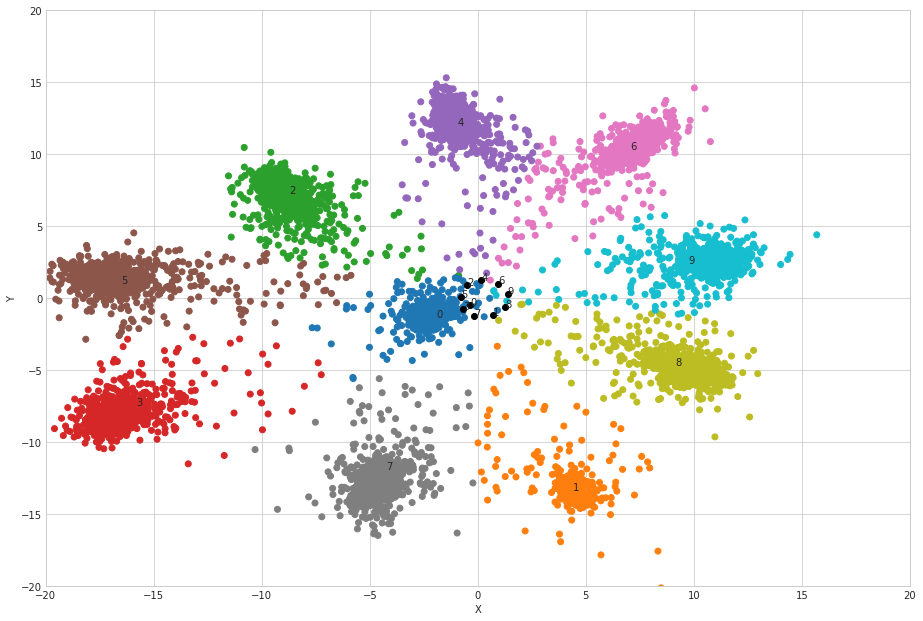

In [28]:
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)



class Plot_Report(object):
    def __init__(self, centers, class_vectors):
        self.fig = plt.figure()
        self.ax = self.fig.add_axes([-2,-2,2,2])
        self.centers = centers
        self.class_vectors = class_vectors
        self.center_names = ["0","1","2","3","4","5","6","7","8","9"]
        self.cmap = colors.ListedColormap(['#1f77b4', '#ff7f0e', 
                              '#2ca02c', '#d62728', 
                              '#9467bd', '#8c564b', 
                              '#e377c2', '#7f7f7f', 
                              '#bcbd22', '#17becf'])
        #self.cmap = discrete_cmap(10, 'cubehelix')
        
    def plot_data(self,x,y,c):
        self.ax.scatter(x,y, c=c , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        
    def plot_centers(self):
        self.ax.scatter(self.centers[:,0],self.centers[:,1], c=[i for i in range(10)] , cmap=self.cmap, vmin=0, vmax=9) #, c=1 cmap=cmap
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.centers[i,0], self.centers[i,1]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
    def plot_class_vectors(self):
        self.ax.scatter(self.class_vectors[0],self.class_vectors[1], c="black")
        for i, txt in enumerate(self.center_names):
            self.ax.annotate(txt, (self.class_vectors[0,i], self.class_vectors[1,i]))
        self.ax.set_xlabel('X')
        self.ax.set_ylabel('Y')
        
    def show(self):
        plt.xlim(-20, 20)
        plt.ylim(-20, 20)
        plt.show()
        
myplot = Plot_Report(np.array(model.centers), model.out.weights[0].numpy())

myplot.plot_data(features[:,0],features[:,1],y_pred_label)
myplot.plot_centers()
myplot.plot_class_vectors()
myplot.show()

In [29]:
np.array(model.centers)

array([[ -1.9242867 ,  -1.2769696 ],
       [  4.4159355 , -13.351339  ],
       [ -8.732005  ,   7.309432  ],
       [-15.808876  ,  -7.420747  ],
       [ -0.93458784,  12.040671  ],
       [-16.497854  ,   1.0617944 ],
       [  7.046907  ,  10.372195  ],
       [ -4.2405353 , -11.8541565 ],
       [  9.1233015 ,  -4.6500025 ],
       [  9.741671  ,   2.439099  ]], dtype=float32)

In [53]:
#Classification vectors
cv_x = model.out.weights[0].numpy()[0]
cv_y = model.out.weights[0].numpy()[0]

In [58]:
model.out.weights[0]

<tf.Variable 'dense_3/kernel:0' shape=(2, 10) dtype=float32, numpy=
array([[ 0.88432413,  0.68028337, -0.6672186 ,  1.2843869 , -0.15179698,
         1.276881  ,  0.08845953, -1.0143772 ,  0.2778069 , -0.8433039 ],
       [-1.3016163 ,  1.279158  , -1.2335091 , -0.55072093,  1.2718129 ,
         0.6290787 , -1.4957021 , -0.35204726,  0.9666587 ,  0.6032002 ]],
      dtype=float32)>